In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
f = 'drive/MyDrive/BABD_projects/'

df = pd.read_csv(f+'complaints_cleaned.csv', index_col=0)

In [4]:
df.shape

(162405, 3)

In [5]:
df.head()

,product,narrative,cleaned_narrative
0,credit_card,purchase order day shipping amount receive pro...,purchase order ship amount receive product wee...
1,credit_card,forwarded message date tue subject please inve...,forward message date subject please investigat...
2,retail_banking,forwarded message cc sent friday pdt subject f...,forwarded message send friday subject final le...
3,credit_reporting,payment history missing credit report speciali...,payment history miss credit report specialize ...
4,credit_reporting,payment history missing credit report made mis...,payment history miss credit report make mistak...


In [6]:
df.isna().sum()

product              0
narrative            0
cleaned_narrative    2
dtype: int64

In [7]:
df['narrative'] = df['narrative'].astype(str)

## 1st task

Each "product" is assigned to a different unit of the CFPB.  
Predicting the product class would streamline the assignment process.

In [8]:
# Train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['narrative'], df['product'], test_size=0.2, random_state=42)

In [9]:
# building a structured representation

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0.1, max_df=0.8)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [10]:
from sklearn.metrics import confusion_matrix, classification_report ,ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

def check_scores(clf, X_train, X_test, y_train, y_test):

    model=clf.fit(X_train, y_train)
    predicted_class=model.predict(X_test)
    predicted_class_train=model.predict(X_train)
    test_probs = model.predict_proba(X_test)
    test_probs = test_probs[:, 1]

    class_names = ['credit_card','credit_reporting','debt_collection','mortgages_and_loans','retail_banking']
    plt.figure(figsize=(10,10))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_train, predicted_class_train),display_labels=class_names)
    disp.plot()
    plt.xticks(rotation=90)
    plt.title("Train Confusion Matrix")
    plt.show()


    plt.figure(figsize=(10,10))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_class),display_labels=class_names)
    disp.plot()
    plt.xticks(rotation=90)
    plt.title("Test Confusion Matrix")
    plt.show()

    print()
    print(classification_report(y_test,predicted_class))
    print()
    train_accuracy = accuracy_score(y_train,predicted_class_train)
    test_accuracy = accuracy_score(y_test,predicted_class)

    print()
    print("Train f1: ", f1_score(y_train, predicted_class_train,average='weighted'))
    print("Test f1: ", f1_score(y_test, predicted_class,average='weighted'))
    print()
    print("Train accuracy score: ", train_accuracy)
    print("Test accuracy score: ",test_accuracy)

    return model

<Figure size 1000x1000 with 0 Axes>

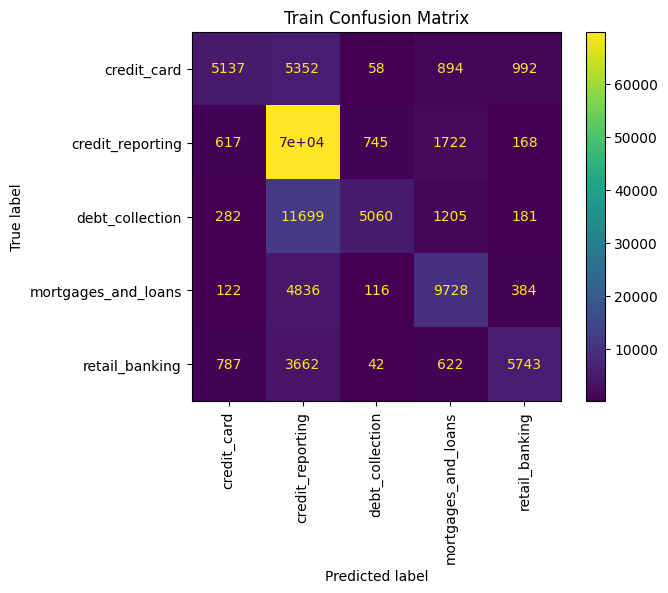

<Figure size 1000x1000 with 0 Axes>

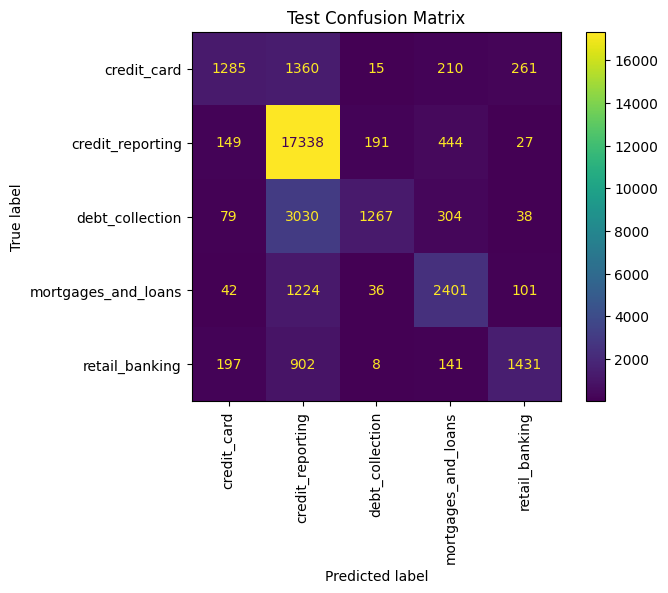


                     precision    recall  f1-score   support

        credit_card       0.73      0.41      0.53      3131
   credit_reporting       0.73      0.96      0.83     18149
    debt_collection       0.84      0.27      0.41      4718
mortgages_and_loans       0.69      0.63      0.66      3804
     retail_banking       0.77      0.53      0.63      2679

           accuracy                           0.73     32481
          macro avg       0.75      0.56      0.61     32481
       weighted avg       0.74      0.73      0.70     32481



Train f1:  0.705162707438794
Test f1:  0.7000810754315054

Train accuracy score:  0.7345679012345679
Test accuracy score:  0.7303346571842


In [60]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb = check_scores(mnb, X_train_tfidf, X_test_tfidf, y_train, y_test)

<Figure size 1000x1000 with 0 Axes>

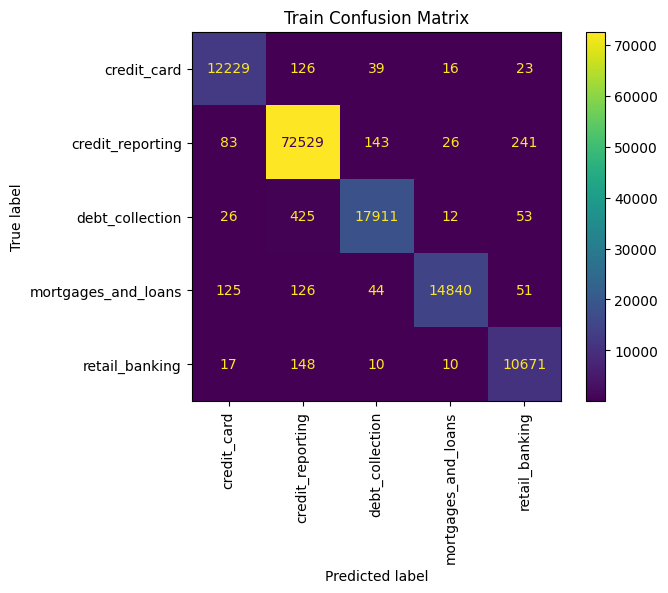

<Figure size 1000x1000 with 0 Axes>

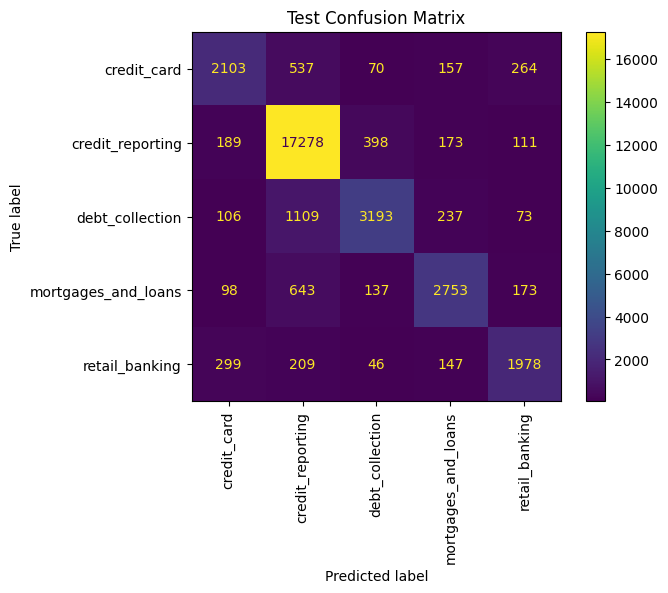


                     precision    recall  f1-score   support

        credit_card       0.75      0.67      0.71      3131
   credit_reporting       0.87      0.95      0.91     18149
    debt_collection       0.83      0.68      0.75      4718
mortgages_and_loans       0.79      0.72      0.76      3804
     retail_banking       0.76      0.74      0.75      2679

           accuracy                           0.84     32481
          macro avg       0.80      0.75      0.77     32481
       weighted avg       0.84      0.84      0.84     32481



Train f1:  0.9865724201484267
Test f1:  0.8363819165267374

Train accuracy score:  0.9865767679566516
Test accuracy score:  0.8406453003294233


In [61]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1)

rfc = check_scores(rfc, X_train_tfidf, X_test_tfidf, y_train, y_test)

import pickle
pickle.dump(rfc, open('rfc_model.pkl', 'wb'))

In [13]:
 # We should not settle for the default parameters
from sklearn.model_selection import GridSearchCV

def grid_search(model, parameters, X_train, Y_train):
    #Doing a grid
    grid = GridSearchCV(estimator=model,
                      param_grid = parameters,
                      cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    #Fitting the grid
    grid.fit(X_train,Y_train)
    # Best model found using grid search
    optimal_model = grid.best_estimator_
    print('Best parameters are: ')
    print( grid.best_params_)

    return optimal_model

In [14]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(5,3,2),(5,3)],  "max_iter": [5000], "alpha": [0.1,1,10]}

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


Best parameters are: 
{'alpha': 0.1, 'hidden_layer_sizes': (5, 3, 2), 'max_iter': 5000}


<Figure size 1000x1000 with 0 Axes>

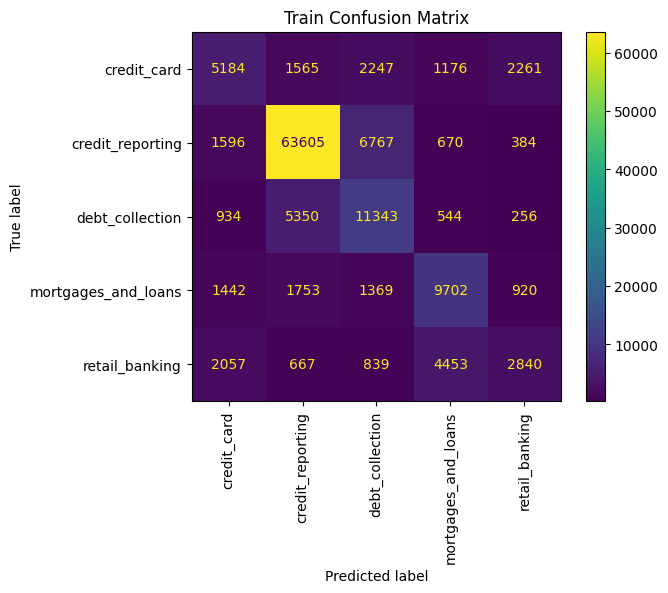

<Figure size 1000x1000 with 0 Axes>

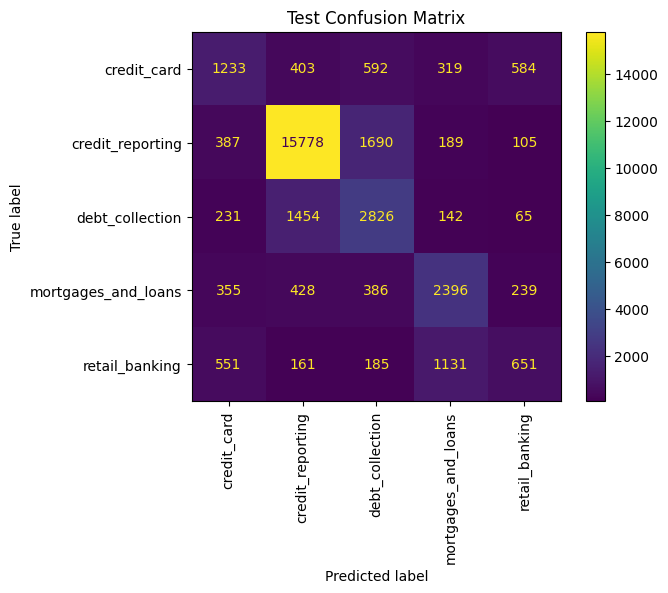


                     precision    recall  f1-score   support

        credit_card       0.45      0.39      0.42      3131
   credit_reporting       0.87      0.87      0.87     18149
    debt_collection       0.50      0.60      0.54      4718
mortgages_and_loans       0.57      0.63      0.60      3804
     retail_banking       0.40      0.24      0.30      2679

           accuracy                           0.70     32481
          macro avg       0.56      0.55      0.55     32481
       weighted avg       0.70      0.70      0.70     32481



Train f1:  0.708851054296847
Test f1:  0.6992536452298106

Train accuracy score:  0.7132939256796281
Test accuracy score:  0.7045349588990487


In [16]:
mpl = grid_search(classifier,parameters,X_train_tfidf, y_train)
mpl = check_scores(mpl, X_train_tfidf, X_test_tfidf, y_train, y_test)

A different approach:

In [10]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True)
tokenizer.fit_on_texts(X_train.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 41728 unique tokens.


In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_lstm = tokenizer.texts_to_sequences(X_train.values)
X_train_lstm = pad_sequences(X_train_lstm, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_lstm.shape)

X_test_lstm = tokenizer.texts_to_sequences(X_test.values)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test_lstm.shape)

Shape of data tensor: (129924, 250)
Shape of data tensor: (32481, 250)


In [12]:
y_train_lstm = pd.get_dummies(y_train).values
print('Shape of label tensor:', y_train_lstm.shape)

y_test_lstm = pd.get_dummies(y_test).values
print('Shape of label tensor:', y_test_lstm.shape)

Shape of label tensor: (129924, 5)
Shape of label tensor: (32481, 5)


In [13]:
import tensorflow as tf

## Model Architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train_lstm.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 250, 256)          365568    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 5563333 (21.22 MB)
Trainable params: 5563333 (21.22 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [14]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer='Nadam', metrics=["CategoricalAccuracy"])

In [15]:
from keras.callbacks import EarlyStopping

num_epochs = 5
batch_size = 128
## For early stopping to try not to overfit
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model.fit(X_train_lstm, y_train_lstm,
                    epochs=num_epochs, batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             patience=3,
                                             min_delta=0.0001)])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


914/914 [==============================] - 143s 150ms/step - loss: 0.5745 - categorical_accuracy: 0.7968 - val_loss: 0.5385 - val_categorical_accuracy: 0.7920
Epoch 2/5
914/914 [==============================] - 77s 84ms/step - loss: 0.3848 - categorical_accuracy: 0.8702 - val_loss: 0.3701 - val_categorical_accuracy: 0.8739
Epoch 3/5
914/914 [==============================] - 66s 72ms/step - loss: 0.3247 - categorical_accuracy: 0.8904 - val_loss: 0.3574 - val_categorical_accuracy: 0.8758
Epoch 4/5
914/914 [==============================] - 65s 71ms/step - loss: 0.2859 - categorical_accuracy: 0.9037 - val_loss: 0.3488 - val_categorical_accuracy: 0.8825
Epoch 5/5
914/914 [==============================] - 61s 66ms/step - loss: 0.2557 - categorical_accuracy: 0.9136 - val_loss: 0.3612 - val_categorical_accuracy: 0.8816


In [17]:
accr = model.evaluate(X_test_lstm,y_test_lstm)
print('Test set\n Accuracy: {:0.3f}'.format(accr[1]))

1016/1016 [==============================] - 14s 14ms/step - loss: 0.3659 - categorical_accuracy: 0.8771
Test set
 Accuracy: 0.877


In [25]:
import numpy as np

# model predicts outputs the probabilty for each class
y_train_pred = model.predict(X_train_lstm)
y_train_pred = np.argmax(y_train_pred,axis=1)

y_test_pred = model.predict(X_test_lstm)
y_test_pred = np.argmax(y_test_pred,axis=1)

1016/1016 [==============================] - 11s 11ms/step


Train f1:  0.925925008666577
Test f1:  0.8758737722670481


<Figure size 1000x1000 with 0 Axes>

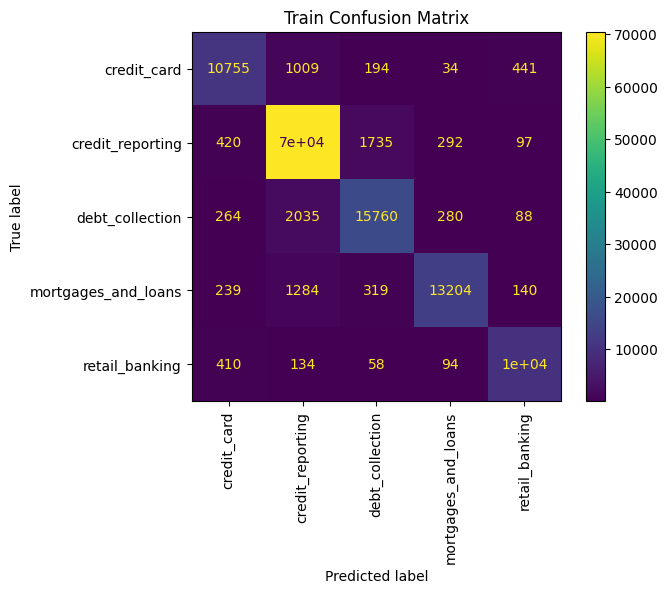

<Figure size 1000x1000 with 0 Axes>

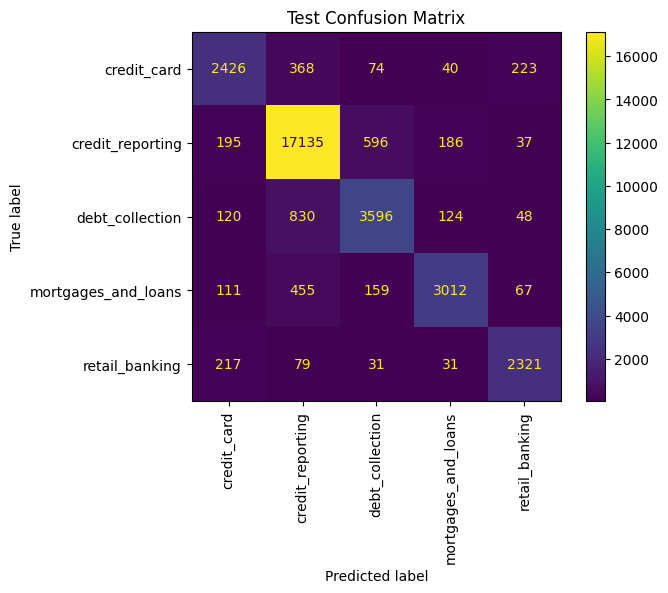

In [49]:
from sklearn.metrics import confusion_matrix, classification_report ,ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

dictionary = { 'credit_card': 0,
               'credit_reporting': 1,
               'debt_collection': 2,
               'mortgages_and_loans': 3,
               'retail_banking': 4}

y_train_enc = y_train.replace(dictionary)
y_test_enc = y_test.replace(dictionary)


print("Train f1: ", f1_score(y_train_enc, y_train_pred, average='weighted'))
print("Test f1: ", f1_score(y_test_enc, y_test_pred, average='weighted'))

class_names = ['credit_card','credit_reporting','debt_collection','mortgages_and_loans','retail_banking']
plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix(y_train_enc, y_train_pred),display_labels=class_names)
disp.plot()
plt.xticks(rotation=90)
plt.title("Train Confusion Matrix")
plt.show()

plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_enc, y_test_pred),display_labels=class_names)
disp.plot()
plt.xticks(rotation=90)
plt.title("Test Confusion Matrix")
plt.show()

### Predicting for new text:

In [11]:
import pickle
rfc = pickle.load(open(f+'rfc_model.pkl', 'rb'))

In [12]:
string = 'you keep you money in a big brown bag inside a zoo'

In [13]:
# note, text should go through the same cleaning procedure
transformed_text = tfidf.transform([string])
rfc.predict(transformed_text)

array(['retail_banking'], dtype=object)

In [14]:
string = 'cash moves everything around me cream get the money'
# note, text should go through the same cleaning procedure
transformed_text = tfidf.transform([string])
rfc.predict(transformed_text)

array(['retail_banking'], dtype=object)

## Working with text does not mean we cannot use known tools: feature importance

In [15]:
feat_importance = pd.DataFrame({'Name': list(tfidf.vocabulary_.keys()),
     'Importance': rfc.feature_importances_})
top_feat_impo = feat_importance.nlargest(10, columns=['Importance'])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'charge'),
  Text(1, 0, 'loan'),
  Text(2, 0, 'time'),
  Text(3, 0, 'card'),
  Text(4, 0, 'immediately'),
  Text(5, 0, 'name'),
  Text(6, 0, 'service'),
  Text(7, 0, 'account'),
  Text(8, 0, 'company'),
  Text(9, 0, 'copy')])

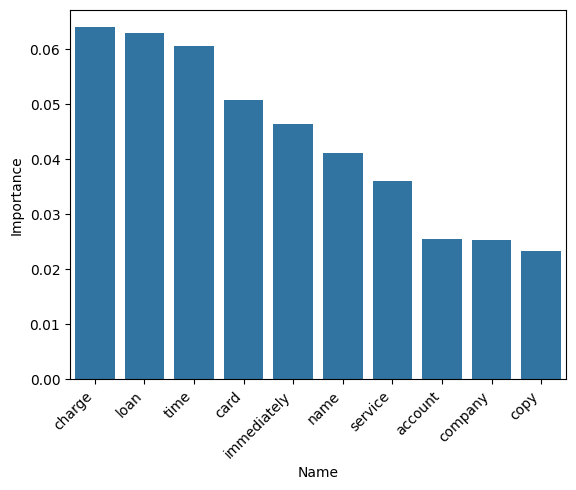

In [16]:
import seaborn as sns
sns.barplot(x=top_feat_impo['Name'], y=top_feat_impo['Importance'])
plt.xticks(rotation=45, ha='right')